Paper - Gradient based learning applied to Document Recognition (link)[https://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf]

helpful resources :  
1. https://medium.com/@siddheshb008/lenet-5-architecture-explained-3b559cb2d52b

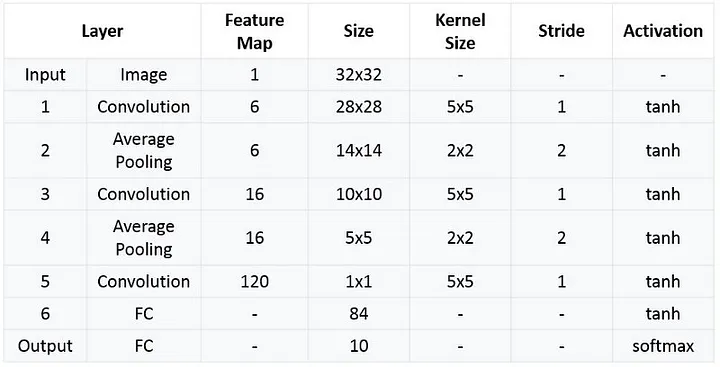

In [67]:
import torch 
from torch import nn
from torchvision import datasets
import torchvision

In [120]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=1)
        self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5) , stride=1)
        self.tanh = nn.Tanh()
        self.linear1 = nn.Linear(in_features=120 , out_features=84)
        self.linear2 = nn.Linear(in_features=84 , out_features=10)


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        # x = x.reshape(x.shape[0], -1)
        # print(x.shape)
        x = self.linear2(self.tanh(self.linear1(x.squeeze())))

        return x



In [62]:
rand_image_tensor = torch.rand(size=(1, 32, 32))
rand_image_tensor.shape

torch.Size([1, 32, 32])

In [63]:
model = LeNet()
model(x=rand_image_tensor)

torch.Size([120, 1, 1])


tensor([ 0.1375, -0.0141, -0.1181,  0.1798, -0.0988, -0.1039, -0.0530,  0.0236,
         0.0032,  0.0157], grad_fn=<ViewBackward0>)

## Getting dataset

In [73]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(32,32)),
    torchvision.transforms.ToTensor()
])


In [74]:
BATCH_SIZE=32


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=data_transform),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=data_transform),
  batch_size=BATCH_SIZE, shuffle=False)

In [75]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [76]:
example_data.shape

torch.Size([32, 1, 32, 32])

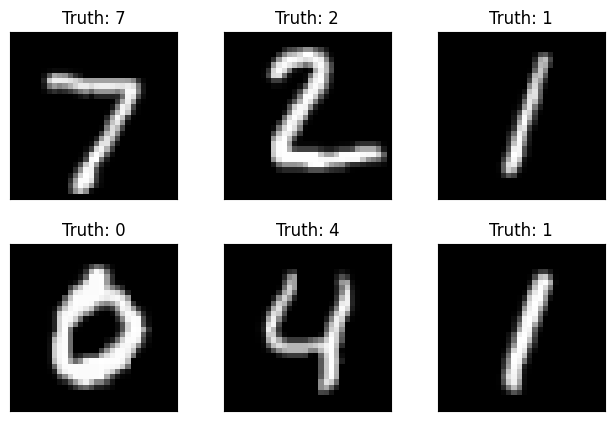

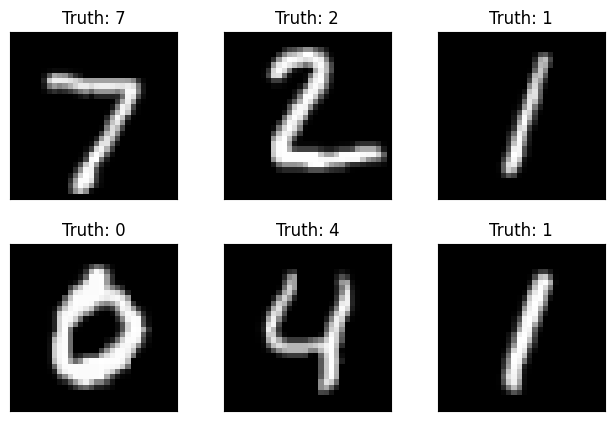

In [78]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Setting up loss and optimzier 

In [80]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, )

## training 

In [108]:
print(example_targets[4])
model(example_data[4]).argmax()

tensor(4)
torch.Size([120, 1, 1])


tensor(0)

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [111]:
# create train step

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  # setup train loss and accuracy per batch
  train_loss, train_acc = 0, 0

  # loop through data loader
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calc loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # optimizer zero
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    # step
    optimizer.step()

    # calc accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # get avg loss and acc per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [112]:

# create test step

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device=device):

  # setup train loss and accuracy per batch
  test_loss, test_acc = 0, 0

  model.eval()

  # loop through data loader
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      # forward pass
      y_pred = model(X)

      # calc loss
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      # calc accuracy
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # get avg loss and acc per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [119]:
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_datalaoder : torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn : torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int =5,
          device=device):

  results= {
      "train_loss" : [],
      "train_acc" : [],
      "test_loss" : [],
      "test_acc" : []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_loader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                       dataloader=test_loader,
                                       loss_fn=loss_fn,
                                       device=device)

    print(f"Epoch {epoch} | Train loss : {train_loss:.4f} | Test loss : {test_loss:.4f} | Train acc : {train_acc:.4f}, test_acc : {test_acc:.4f} ")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [121]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 3

model_0 = LeNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(model=model_0, train_datalaoder=train_loader,
                        test_dataloader=test_loader, loss_fn=loss_fn,
                        optimizer=optimizer, epochs=NUM_EPOCHS,
                        )

end_time = timer()
print(f"total train time : {end_time - start_time:.3f} seconds")

 33%|███▎      | 1/3 [00:12<00:25, 12.66s/it]

Epoch 0 | Train loss : 0.2290 | Test loss : 0.1019 | Train acc : 0.9330, test_acc : 0.9682 


 67%|██████▋   | 2/3 [00:25<00:12, 12.48s/it]

Epoch 1 | Train loss : 0.0765 | Test loss : 0.0550 | Train acc : 0.9764, test_acc : 0.9819 


100%|██████████| 3/3 [00:37<00:00, 12.53s/it]

Epoch 2 | Train loss : 0.0556 | Test loss : 0.0542 | Train acc : 0.9828, test_acc : 0.9831 
total train time : 37.577 seconds


In [124]:
model_0_results

{'train_loss': [0.22898623507246374, 0.07651761077865958, 0.05564518774735431],
 'train_acc': [0.9330166666666667, 0.97635, 0.98275],
 'test_loss': [0.10187623101121451, 0.054974578750749736, 0.05422518037721893],
 'test_acc': [0.9681509584664537, 0.9819289137380192, 0.9831269968051118]}

In [123]:
def plot_loss_curves(results):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # how many epochs?
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(13,7))
  #loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train loss')
  plt.plot(epochs, test_loss, label='test loss')
  plt.title("loss")
  plt.xlabel('Epochs')
  plt.legend()
  #accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend()

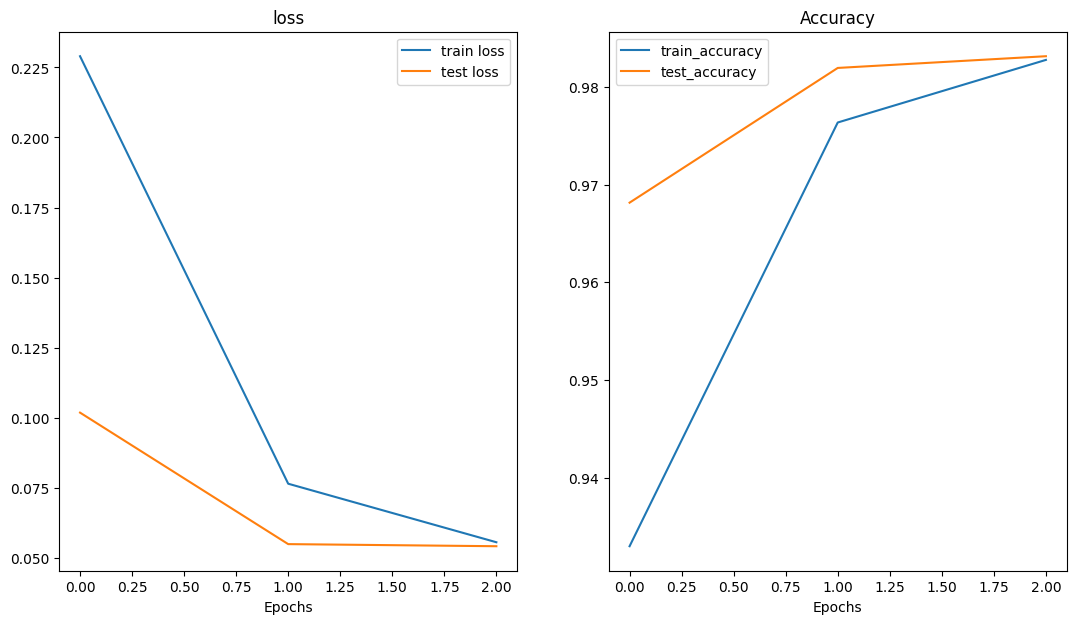

In [144]:
plot_loss_curves(model_0_results)

Text(0.5, 1.0, 'Truth: 7')

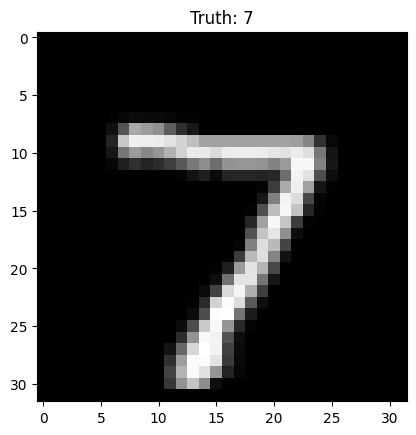

In [133]:
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.title("Truth: {}".format(example_targets[0]))

In [141]:
torch.eq(torch.tensor(1),torch.tensor(1))

tensor(True)

In [143]:
for i in range(10):
    target = example_targets[i]
    prediction = model_0(example_data[i][0].unsqueeze(0)).argmax()
    print(f'Actual digit:  {target.item()}')
    print(f'Predicted digit : {prediction.item()}')
    print(f'Is the prediciton correct : {torch.eq(target, prediction)}\n')
    # break

Actual digit:  7
Predicted digit : 7
Is the prediciton correct : True

Actual digit:  2
Predicted digit : 2
Is the prediciton correct : True

Actual digit:  1
Predicted digit : 1
Is the prediciton correct : True

Actual digit:  0
Predicted digit : 0
Is the prediciton correct : True

Actual digit:  4
Predicted digit : 4
Is the prediciton correct : True

Actual digit:  1
Predicted digit : 1
Is the prediciton correct : True

Actual digit:  4
Predicted digit : 4
Is the prediciton correct : True

Actual digit:  9
Predicted digit : 9
Is the prediciton correct : True

Actual digit:  5
Predicted digit : 6
Is the prediciton correct : False

Actual digit:  9
Predicted digit : 9
Is the prediciton correct : True

